# DNA Project

## Introduction

In this project, we aim to analyse and compare DNA fragments to find common patters in the DNA sequence.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import khiva as kv
import time

In [2]:
from khiva.library import *
set_backend(KHIVABackend.KHIVA_BACKEND_CPU)
set_device(0)
print(get_backend_info())

ArrayFire v3.6.2 (CPU, 64-bit Windows, build dc38ef13)
[0] Intel: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, 16206 MB, Max threads(8) 



## Converting the sequence to a time series

The DNA sequence is made up of four bases, A (adenine), G (guanine), C (cytosine) and T (thymine). However, in other to analyse the sequence efficiently, we need to convert this bases to a numerical values.

The first function, translates each base to a numerical value. The second one, turns the DNA chain to a numerical time series.


In [3]:
def valueForSymbol(symbol):
    if (symbol == "A"): 
        return 2.0
    elif (symbol == "G"):
        return 1.0
    elif (symbol == "C"):
        return -1.0
    elif (symbol == "T"):
        return -2.0
    elif (symbol == ""):
        return 0.0
    else: 
        raise Exception("Symbol not understood")

In [4]:
def dnaNumConversion(dna):
    arr = np.zeros(shape=(len(dna)+1))
    for a in range(len(dna)):
        arr[a+1] = valueForSymbol(dna[a])
    return np.cumsum(arr)
        
    

DNA = ['G','C','G','T','A']

dnaNumConversion(DNA)

array([ 0.,  1.,  0.,  1., -1.,  1.])

## Converting the time series to a DNA sequence

This 2 functions reverse the previous funcions, in case we want to translate back the numerical values to the original base sequence.

In [5]:
def symbolForValue(value):
    if (value == 2.0):
        return "A"
    elif (value == 1.0):
        return "G"
    elif (value == -1.0):
        return "C"
    elif (value == -2.0):
        return "T"
    elif (value == 0):
        return ""
    else:
        raise Exception("Value not understood")

In [6]:
def numDnaConversion(num):
    arr = np.diff(num)
    dna = np.empty(shape=(len(arr)), dtype=str)
    for a in range(len(arr)):
        dna[a] = symbolForValue(arr[a])
    return dna
    

z = [0,1,3,5,7]
    
numDnaConversion(z) 

array(['G', 'A', 'A', 'A'], dtype='<U1')

This is an example of how we turn a DNA sequence to a numerical one, which we can then plot.

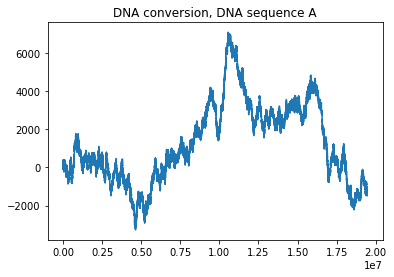

In [7]:
dna1_file = open('dna_a.data', 'r')
dna1_file = dna1_file.read()
dna1_file = dna1_file.replace('\n', '')
dna1_file = list(dna1_file)

time_series_a = dnaNumConversion(dna1_file)

plt.plot(range(len(time_series_a)),time_series_a)
plt.title('DNA conversion, DNA sequence A')
plt.show()

## Finding matches

Here, we use Khiva's library to find the 3 best matches for a motif in a DNA sequence.

In [8]:
from khiva.dimensionality import paa
from khiva.matrix import mass
from khiva.normalization import decimal_scaling_norm_in_place, decimal_scaling_norm

After getting an array with the indices of the time series in order of closeness to the query, we need to discard indices which are too much alike and would give the same match after further refinement.

In [9]:
def valueNotWithinWindow(previous_values, a, window):
    return all(a < (pre_val-window) or a > (pre_val+window) for pre_val in previous_values)    

In [10]:
def selectValue(previous_values, arr, window):
    value = 0
    for a in arr:
        if valueNotWithinWindow(previous_values, a, window) == True:
            value = a
    return value

This function selects a section of DNA; given the desired length, the position of the first element and a small margin to be added at either side of the section (to make further analysing more accurate).

In [11]:
def selectSection(index_array, match_no, length, window, time_series):
    start = int(index_array[match_no] - window)
    end = int(index_array[match_no] + length + window)
    section = time_series[start:end]
    return section

Next, we define a function that finds the refined location (index) of the match; given the selected section, the query and the time series.

In [12]:
def refineMatch(time_series, query, section):
    arr_kv = kv.Array(section)
    distances = mass(query, arr_kv)
    arr_np = distances.to_numpy()
    location = arr_np.argmin()
    return location

In order to make a fair comparison between the DNA fragments, we need to use the same scales. To do this, we need to normalise the time series.

In [13]:
def normalizeDnaSequence(sequence):
    sequence = sequence.tolist()
#     num_seq = dnaNumConversion(sequence)
    num_seq_kv = kv.Array(sequence)
    decimal_scaling_norm_in_place(num_seq_kv)
    return num_seq_kv

The following function finally identifies and returns the 3 best matches in the sequence for a particular query. It applies the previuos functions defined above.

It works by initially getting rough estimates of the locations of the best coincidences within the chain and later refining these estimates to get better approximation.

Additionally, it plots the query and the matches separately, as well as everything together to make a comparison easier to make. 

In [14]:
def findSequence(query, time_series, reduction=4):
    reduced_time_series = paa(time_series, len(time_series)//reduction)
    reduced_query = paa(query, len(query)//reduction)
    rough_dis = mass(reduced_query, reduced_time_series)
    
    rough_dis = rough_dis.to_numpy()
    
    arr = np.argsort(rough_dis)
    arr = arr * reduction

    time_series = time_series.to_numpy()
    
    length = len(query)
    window = length // 2
    
    index_array = np.zeros(shape=3)
    index_array[0] = arr[0] 
    index_array[1] = selectValue([index_array[0]], arr, window)
    index_array[2] = selectValue([index_array[0], index_array[1]], arr, window)
    
    time_series = np.insert(time_series, [len(time_series)], [0]*(window))
    time_series = np.insert(time_series, [0], [0]*(window))
 
    for index in range(len(index_array)):
        index_array[index] += window

    section_a = selectSection(index_array, 0, length, window, time_series)
    section_b = selectSection(index_array, 1, length, window, time_series)
    section_c = selectSection(index_array, 2, length, window, time_series)
    
    index_a = refineMatch(time_series, query, section_a)    
    index_b= refineMatch(time_series, query, section_b)    
    index_c = refineMatch(time_series, query, section_c)   
    
    a = time_series[index_a:index_a+length]
    b = time_series[index_b:index_b+length]
    c = time_series[index_c:index_c+length]
    
    query_norm = decimal_scaling_norm(eg2)
    a_norm = normalizeDnaSequence(a)
    b_norm = normalizeDnaSequence(b)
    c_norm = normalizeDnaSequence(c)    

    plt.plot(query_norm.to_numpy())
    plt.title('Query:')
    plt.show()
        
    plt.plot(a_norm.to_numpy())
    plt.title(f'First best match, index {index_a}:')
    plt.show()

    plt.plot(b_norm.to_numpy())
    plt.title(f'Second best match, index {index_b}:')
    plt.show()

    plt.plot(c_norm.to_numpy())
    plt.title(f'Third best match, index {index_c}:')
    plt.show()
    
    plt.plot(query_norm.to_numpy(), label='Query')
    plt.plot(a_norm.to_numpy(), label=f'Index {index_a}')
    plt.plot(b_norm.to_numpy(), label=f'Index {index_b}')
    plt.plot(c_norm.to_numpy(), label=f'Index {index_c}')
    plt.title('Comparison')
    plt.legend()
    plt.show()
    
    a_seq = numDnaConversion(a)
    b_seq = numDnaConversion(b)
    c_seq = numDnaConversion(c)
    
    return a_seq, b_seq , c_seq

In [15]:
dna2_file = open('dna_b.data', 'r')
dna2_file = dna2_file.read()
dna2_file = dna2_file.replace('\n', '')
dna2_file = list(dna2_file)

time_series_b = dnaNumConversion(dna2_file)

tsa = kv.Array(time_series_a)
tsb = kv.Array(time_series_b)

query = kv.Array(tsb[:200])

eg1 = kv.Array(time_series_a[:1000])
eg2 = kv.Array(time_series_a[:40])

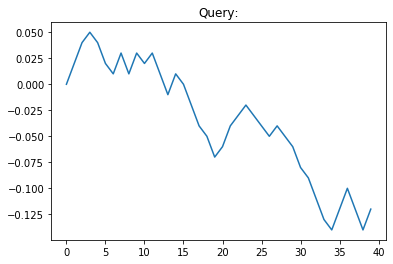

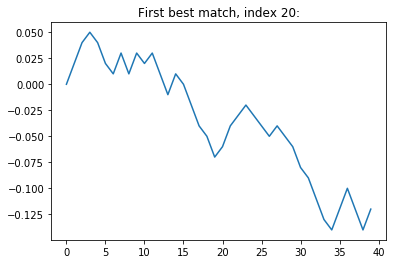

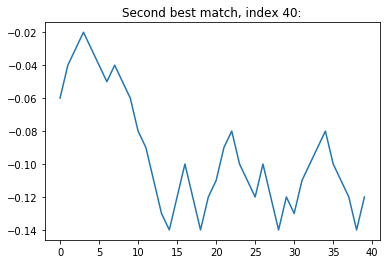

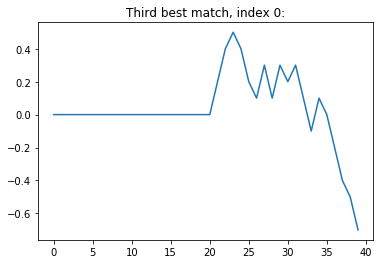

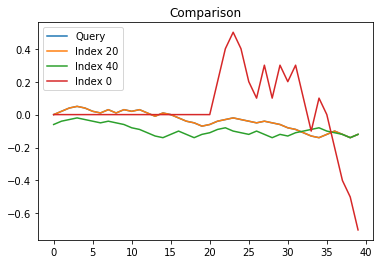

39


In [96]:
a, b, c = findSequence(eg2, eg1)
print(len(a))

In [ ]:
tsa = kv.Array(time_series_a)
findSequence(query, tsa)

## Determining the accuracy of our method

In order to check how accurate our method was, we used of a variation of the Levenshtein or edit distance. After converting everything back to a DNA base sequence, we calculated the number of base substitutions that would need to occur for the query and the resulting closest match to be equal. After this, we can get the accuracy of the match by finding the percentage of similarity between the query and the match.

In [97]:
def minSubstitutionsAccuracy(query, match):
    query = numDnaConversion(query)
    substitutions = 0
    for letter in range(len(query)):
        if query[letter] != match[letter]:
            substitutions += 1
    accuracy = (len(query)-substitutions)/len(query)
    return accuracy

In [98]:
eg2 = eg2.to_numpy()
print(minSubstitutionsAccuracy(eg2, a))
print(minSubstitutionsAccuracy(eg2, b))
print(minSubstitutionsAccuracy(eg2, c))

1.0
0.358974358974359
0.1794871794871795


## Finding a repeating pattern within a DNA chain

Now, we find the subsequence which has the closest match with another subsequence within a DNA chain.

In [99]:
from khiva.matrix import matrix_profile_self_join, find_best_n_motifs, find_best_n_occurrences

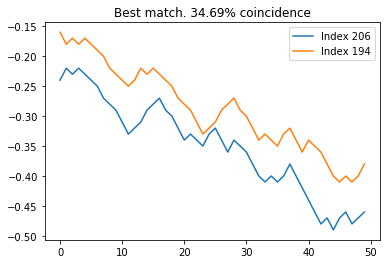

In [100]:
def findMotifInTimeSeries(time_series, length_of_motif):
    profile, index = matrix_profile_self_join(time_series, length_of_motif)
    distance, ref_index, query_index = find_best_n_motifs(profile, index, length_of_motif, 3, self_join=True)
    
    ref_index = ref_index.to_numpy()
    query_index = query_index.to_numpy()

    section_a = time_series.to_numpy()[ref_index[0]:ref_index[0]+length_of_motif]
    section_b = time_series.to_numpy()[query_index[0]:query_index[0]+length_of_motif]
    
    sect_a_converted = numDnaConversion(section_a)
    
    accuracy = minSubstitutionsAccuracy(section_b, sect_a_converted)
    accuracy = round(accuracy, 4)
    
    section_a_norm = normalizeDnaSequence(section_a)
    section_b_norm = normalizeDnaSequence(section_b)
    
    plt.plot(section_a_norm.to_numpy(), label=f'Index {ref_index[0]}')
    plt.plot(section_b_norm.to_numpy(), label=f'Index {query_index[0]}')
    plt.title(f'Best match. {accuracy*100}% coincidence')
    plt.legend()
    plt.show()
   
    
findMotifInTimeSeries(eg1, 50)    

In [ ]:
findMotifInTimeSeries(tsa, 200) 

## Finding a common motif between two DNA chains

Lastly, we do the same thing between two chains.

In [101]:
from khiva import matrix_profile

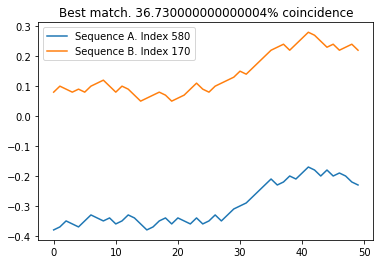

In [102]:
def findMotifBetween2Sequences(time_series_ref, time_series_query, length_of_motif):
    profile, index = matrix_profile(time_series_ref, time_series_query, length_of_motif)
    distance, ref_index, query_index = find_best_n_motifs(profile, index, length_of_motif, 1, self_join=False)
    
    ref_index = ref_index.to_numpy()
    query_index = query_index.to_numpy()
    
    section_a = time_series_ref.to_numpy()[ref_index[0]:ref_index[0]+length_of_motif]
    section_b = time_series_query.to_numpy()[query_index[0]:query_index[0]+length_of_motif]
    
    sect_a_converted = numDnaConversion(section_a)
    
    accuracy = minSubstitutionsAccuracy(section_b, sect_a_converted)
    accuracy = round(accuracy, 4)
    
    section_a_norm = normalizeDnaSequence(section_a)
    section_b_norm = normalizeDnaSequence(section_b)
    
    plt.plot(section_a_norm.to_numpy(), label=f'Sequence A. Index {ref_index[0]}')
    plt.plot(section_b_norm.to_numpy(), label=f'Sequence B. Index {query_index[0]}')
    plt.title(f'Best match. {accuracy*100}% coincidence')
    plt.legend()
    plt.show()
    
eg3 = kv.Array(time_series_a[1000:2000])
findMotifBetween2Sequences(eg1, eg3, 50)

In [ ]:
findMotifBetween2Sequences(tsa, tsb, 150)